In [1]:
# !kaggle competitions download -c titanic -p "./dataset/"

In [2]:
# !unzip ./dataset/titanic.zip -d ./dataset && rm ./dataset/titanic.zip

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_filepath = "./dataset/train.csv"
test_filepath = "./dataset/test.csv"
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


결측치 보정

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


<h1>Pclass와 생존</h1>

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


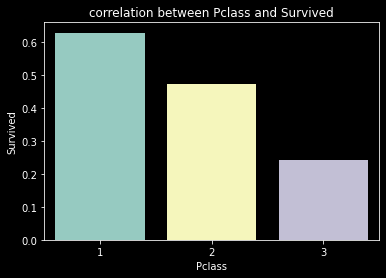

In [8]:
cor_Pclass_Survived = train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(cor_Pclass_Survived)
# plt.figure(figsize=(6,6))
plt.title("correlation between Pclass and Survived")
sns.barplot(x=cor_Pclass_Survived["Pclass"], y=cor_Pclass_Survived["Survived"]);
#groupby에 as_index를 False로 하면 Pclass를 Index로 사용하지 않음
#ascending : 오름차순

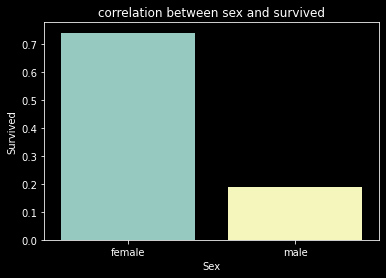

In [9]:
cor_Sex_Survived = train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by="Survived", ascending=False)
plt.title("correlation between sex and survived")
sns.barplot(x=cor_Sex_Survived["Sex"], y=cor_Sex_Survived["Survived"]);

/Users/ohyeonsu/miniforge3/envs/tf25/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 72.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/ohyeonsu/miniforge3/envs/tf25/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


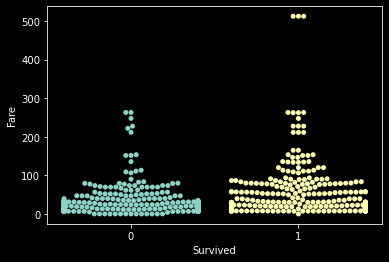

In [10]:
sns.swarmplot(x=train["Survived"], y=train["Fare"]);

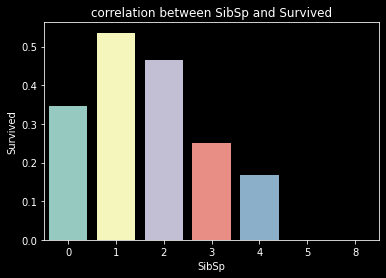

In [11]:
cor_SibSp_Survived = train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values("Survived", ascending=False)
plt.title("correlation between SibSp and Survived")
sns.barplot(x = cor_SibSp_Survived["SibSp"], y=cor_SibSp_Survived["Survived"]);

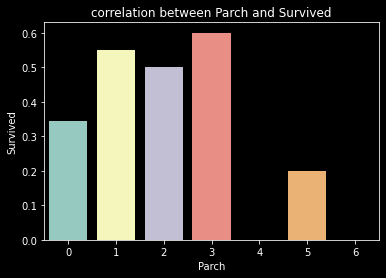

In [12]:
cor_Parch_Survived = train[["Parch","Survived"]].groupby(["Parch"], as_index=False).mean().sort_values("Survived", ascending=False)
plt.title("correlation between Parch and Survived")
sns.barplot(x=cor_Parch_Survived["Parch"], y=cor_Parch_Survived["Survived"]);

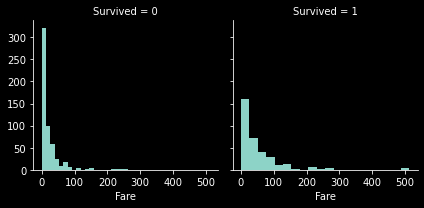

In [13]:
g = sns.FacetGrid(train, col="Survived")
g.map(plt.hist, 'Fare', bins=20);

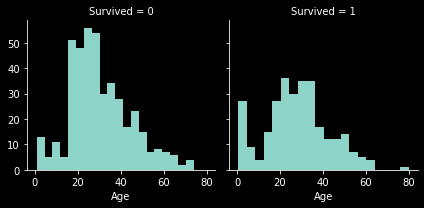

In [14]:
g = sns.FacetGrid(train, col="Survived")
g.map(plt.hist, 'Age', bins=20);

In [15]:
train["Title"] = train["Name"].str.extract('([A-Za-z]+)\.')
    
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


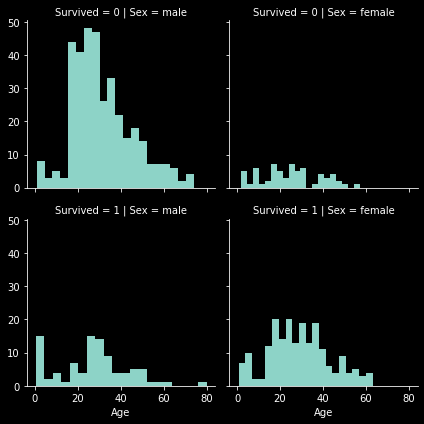

In [16]:
g = sns.FacetGrid(train, col="Sex", row="Survived")
g.map(plt.hist, 'Age', bins=20);

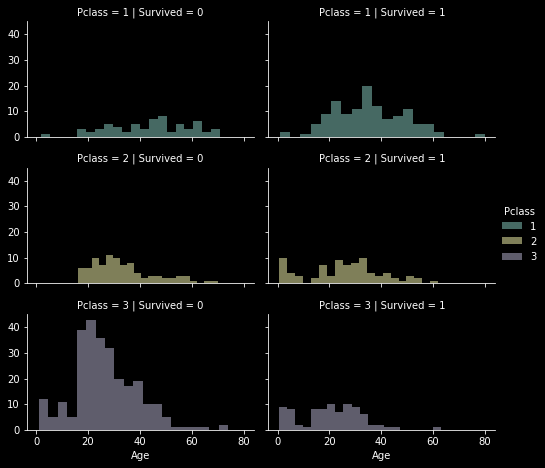

In [17]:
grid = sns.FacetGrid(train, col="Survived", row="Pclass",hue="Pclass",height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5,bins=20)
grid.add_legend();

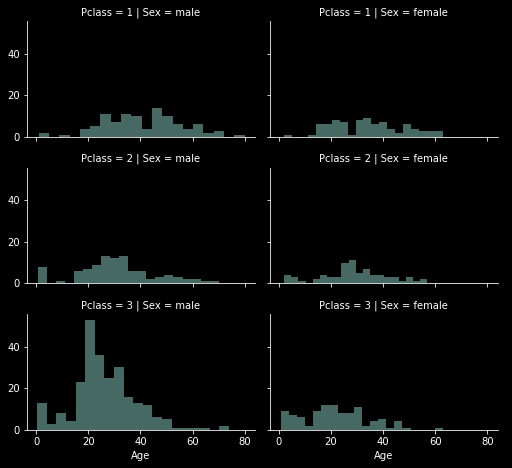

In [18]:
grid = sns.FacetGrid(train, row="Pclass", col="Sex", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [19]:
df = train.corr()
df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


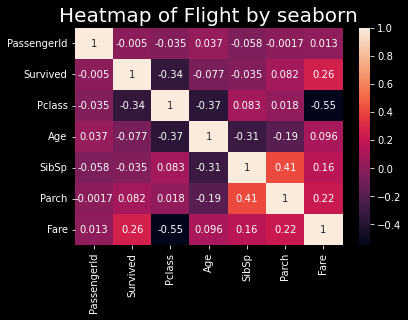

In [20]:
# heatmap by seaborn
ax = sns.heatmap(df, annot=True)
plt.title('Heatmap of Flight by seaborn', fontsize=20)
plt.show()

In [21]:
print(train.columns)
print(train.shape)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')
(891, 13)


In [22]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64

Cabin 칼럼의 경우 결측치의 비중이 너무 높으므로 남은 데이터로 추정하면 노이즈만 증가할 것으로 보이므로 제거

In [23]:
data = train,test
print(type(data))

<class 'tuple'>


In [24]:
for element in data:
    element.drop(['Cabin'], axis=1, inplace=True)

In [25]:
for element in data:
    element[element["Embarked"].isnull()].fillna("S")

In [26]:
for element in data:
    element['Title'] = element.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [27]:
for element in data:
    print(pd.crosstab(element["Title"], element["Sex"]))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
Sex     female  male
Title               
Col          0     2
Dona         1     0
Dr           0     1
Master       0    21
Miss        78     0
Mr           0   240
Mrs         72     0
Ms           1     0
Rev          0     2


In [28]:
for element in data:
    element['Title'] = element['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    element['Title'] = element['Title'].replace('Mlle', 'Miss')
    element['Title'] = element['Title'].replace('Ms', 'Miss')
    element['Title'] = element['Title'].replace('Mme', 'Mrs')

In [29]:
for element in data:
    element.groupby('Title')["Age"].mean()

In [30]:
for element in data:
    element.loc[(element.Age.isnull()) & (element.Title=='Master'), 'Age'] = 4.5742
    element.loc[(element.Age.isnull()) & (element.Title=='Miss'), 'Age'] = 21.846
    element.loc[(element.Age.isnull()) & (element.Title=='Mr'), 'Age'] = 32.368
    element.loc[(element.Age.isnull()) & (element.Title=='Mrs'), 'Age'] = 35.789
    element.loc[(element.Age.isnull()) & (element.Title=='Rare'), 'Age'] = 45.545

In [31]:
a,b = data
a = pd.get_dummies(a, columns=["Title", "Embarked"]).copy()
b = pd.get_dummies(b, columns=["Title", "Embarked"]).copy()
data=a,b

In [32]:
for element in data:
    element['Age'] = element['Age'].astype(float)/100
    print(element)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex      Age  \
0                              Braund, Mr. Owen Harris    male  0.22000   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  0.38000   
2                               Heikkinen, Miss. Laina  female  0.26000   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  0.35000   
4                             Allen, Mr. William Henry    male  0.35000   
..                                                 ...     ...      ...   
886               

In [33]:
# for element in data:
#     element['AgeBand'] = pd.cut(element['Age'], 5)

In [34]:
# for element in data:
#     element.loc[ element['Age'] <= 16, 'Age'] = 0
#     element.loc[(element['Age'] > 16) & (element['Age'] <= 32), 'Age'] = 1
#     element.loc[(element['Age'] > 32) & (element['Age'] <= 48), 'Age'] = 2
#     element.loc[(element['Age'] > 48) & (element['Age'] <= 64), 'Age'] = 3
#     element.loc[ element['Age'] > 64, 'Age']
#     element = element.drop(['AgeBand'], axis=1,inplace=True)

In [35]:
for element in data:
    element['FamilySize'] = element['SibSp'] + element['Parch'] + 1

In [36]:
# train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [37]:
for element in data:
    element['IsAlone'] = 0
    element.loc[element['FamilySize'] == 1, 'IsAlone'] = 1

In [38]:
# train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [39]:
for element in data:
    element['Sex'] = element["Sex"].astype('category')
    print(element.Sex.cat.categories)
    print(element.Sex.cat.codes.head(5))

    element["Sex"] = element.Sex.cat.codes

Index(['female', 'male'], dtype='object')
0    1
1    0
2    0
3    0
4    1
dtype: int8
Index(['female', 'male'], dtype='object')
0    1
1    0
2    1
3    1
4    0
dtype: int8


In [40]:
for element in data:
    element['Fare'].fillna(element['Fare'].dropna().median(), inplace=True)
    print(element.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  0.22      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  0.38      1      0   
2                             Heikkinen, Miss. Laina    0  0.26      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  0.35      1      0   
4                           Allen, Mr. William Henry    1  0.35      0      0   

             Ticket     Fare  Title_Master  Title_Miss  Title_Mr  Title_Mrs  \
0         A/5 21171   7.2500             0           0         1          0   
1          PC 17599  71.2833             0           0         0          1   
2  STON/O2. 3101282   7.9250             0           1     

In [41]:
for element in data:
    element['FareBand'] = pd.qcut(element['Fare'], 4)
    # train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

In [42]:
for element in data:
    element.loc[ element['Fare'] <= 7.91, 'Fare'] = 0
    element.loc[(element['Fare'] > 7.91) & (element['Fare'] <= 14.454), 'Fare'] = 1
    element.loc[(element['Fare'] > 14.454) & (element['Fare'] <= 31), 'Fare']   = 2
    element.loc[ element['Fare'] > 31, 'Fare'] = 3
    element['Fare'] = element['Fare'].astype(int)

    element = element.drop(['FareBand'], axis=1,inplace=True)

In [43]:
a,b = data
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    int8   
 5   Age           891 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    int64  
 10  Title_Master  891 non-null    uint8  
 11  Title_Miss    891 non-null    uint8  
 12  Title_Mr      891 non-null    uint8  
 13  Title_Mrs     891 non-null    uint8  
 14  Title_Rare    891 non-null    uint8  
 15  Embarked_C    891 non-null    uint8  
 16  Embarked_Q    891 non-null    uint8  
 17  Embarked_S    891 non-null    uint8  
 18  FamilySize    891 non-null    

In [44]:
data[1].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,892,3,"Kelly, Mr. James",1,0.345,0,0,330911,0,0,0,1,0,0,0,1,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,0.470,1,0,363272,0,0,0,0,1,0,0,0,1,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,0.620,0,0,240276,1,0,0,1,0,0,0,1,0,1,1
3,895,3,"Wirz, Mr. Albert",1,0.270,0,0,315154,1,0,0,1,0,0,0,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,0.220,1,1,3101298,1,0,0,0,1,0,0,0,1,3,0


In [45]:
for element in data:
    element = element.drop(['PassengerId', 'Name', "SibSp", "Parch", "Ticket"],axis = 1, inplace=True)

              Survived    Pclass       Sex       Age      Fare  Title_Master  \
Survived      1.000000 -0.338481 -0.543351 -0.089401  0.295875      0.085221   
Pclass       -0.338481  1.000000  0.131900 -0.343799 -0.628459      0.082081   
Sex          -0.543351  0.131900  1.000000  0.117474 -0.248940      0.159934   
Age          -0.089401 -0.343799  0.117474  1.000000  0.069150     -0.411435   
Fare          0.295875 -0.628459 -0.248940  0.069150  1.000000      0.154223   
Title_Master  0.085221  0.082081  0.159934 -0.411435  0.154223      1.000000   
Title_Miss    0.335636 -0.010261 -0.693916 -0.305249  0.060825     -0.110981   
Title_Mr     -0.549199  0.142698  0.867334  0.231105 -0.323790     -0.254903   
Title_Mrs     0.341994 -0.153758 -0.550146  0.184386  0.260449     -0.087987   
Title_Rare   -0.012054 -0.187174  0.075638  0.193626  0.078429     -0.035291   
Embarked_C    0.168240 -0.243292 -0.082853  0.041755  0.200659     -0.035225   
Embarked_Q    0.003650  0.221009 -0.0741

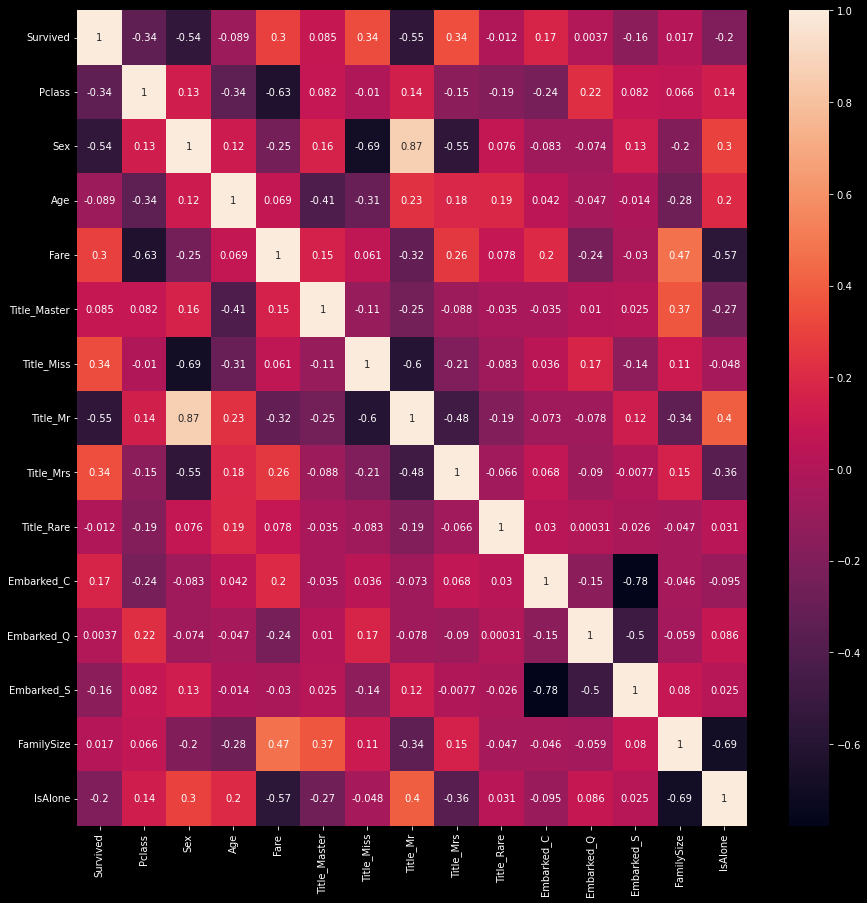

In [46]:
df = data[0].corr()
plt.figure(figsize=(15,15))
sns.heatmap(df, annot=True)
print(df)

In [47]:
#Pclass, IsAlone, Rare는 개선이 필요, Age도 개선 필요, Pclass, Sex는 왜 이상하냐 ㅅㅂ

In [48]:
for element in data:
    element = element.drop(['FamilySize'],axis = 1, inplace=True)

In [49]:
train, test = data

X_train = train.drop("Survived",axis = 1)
Y_train = train["Survived"]
X_train.shape, Y_train.shape

((891, 13), (891,))

In [50]:
X_train

,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S,IsAlone
0,3,1,0.22000,0,0,0,1,0,0,0,0,1,0
1,1,0,0.38000,3,0,0,0,1,0,1,0,0,0
2,3,0,0.26000,1,0,1,0,0,0,0,0,1,1
3,1,0,0.35000,3,0,0,0,1,0,0,0,1,0
4,3,1,0.35000,1,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,0.27000,1,0,0,0,0,1,0,0,1,1
887,1,0,0.19000,2,0,1,0,0,0,0,0,1,1
888,3,0,0.21846,2,0,1,0,0,0,0,0,1,0
889,1,1,0.26000,2,0,0,1,0,0,1,0,0,1


In [51]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train, test_size=0.3, shuffle=True)

In [64]:
model = Sequential()
model.add(Dense(138, input_dim=13, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 138)               1932      
_________________________________________________________________
dropout_6 (Dropout)          (None, 138)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               17792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 19,853
Trainable params: 19,853
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
8/8 [==============================] - 1s 34ms/step - loss: 0.6512 - accuracy: 0.5857 - val_loss: 0.5934 - val_accuracy: 0.6480

Epoch 00001: val_loss improved from inf to 0.59343, saving model to ./model/01-0.5934.hdf5
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5848 - accuracy: 0.6756 - val_loss: 0.5452 - val_accuracy: 0.6872

Epoch 00002: val_loss improved from 0.59343 to 0.54518, saving model to ./model/02-0.5452.hdf5
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5311 - accuracy: 0.7444 - val_loss: 0.5347 - val_accuracy: 0.7151

Epoch 00003: val_loss improved from 0.54518 to 0.53466, saving model to ./model/03-0.5347.hdf5
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5150 - accuracy: 0.7416 - val_loss: 0.5036 - val_accuracy: 0.7151

Epoch 00004: val_loss improved from 0.53466 to 0.50359, saving model to ./model/04-0.5036.hdf5
Epoch 5/500
8/8 [==============================] - 0s 8ms/step 

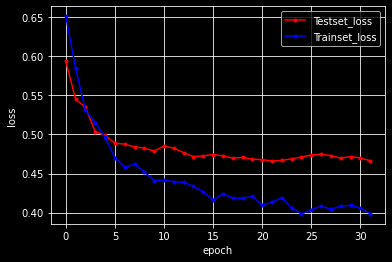

In [65]:
#모델 최적화 진행
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor="val_loss", verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),epochs=500, batch_size=100, callbacks=[early_stopping_callback, checkpointer])

y_vloss = history.history['val_loss']

y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [66]:
print("\n Accuracy: %.4f" % (model.evaluate(X_valid, Y_valid)[1]))

6/6 [==============================] - 0s 7ms/step - loss: 0.4663 - accuracy: 0.7765

 Accuracy: 0.7765


In [67]:
pred = model.predict(test)
pred = pd.DataFrame(pred, columns=['Survived'])
print(pred.head())
series = pd.Series([i for i in range(892, 1310)])
pred.loc[:,'PassengerID'] = series
pred = pred[["PassengerID", "Survived"]]
pred["Survived"] = pred[["Survived"]].round().astype(int)
pred.to_csv('./predict.csv', index = False)

   Survived
0  0.037436
1  0.524417
2  0.055254
3  0.119614
4  0.475367
